In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
### 週販レポート2025年版

# 標準ライブラリ
from datetime import datetime, timedelta

# サードパーティライブラリ
import pandas as pd
from pandas import Timedelta
import matplotlib.pyplot as plt
import japanize_matplotlib
from matplotlib.ticker import ScalarFormatter
from IPython.display import Markdown, display

# プロジェクト内モジュール
from gamedata import hard_sales as hs
from gamedata import plot_hard as ph
from gamedata import hard_info as hi
from gamedata import hard_event as he


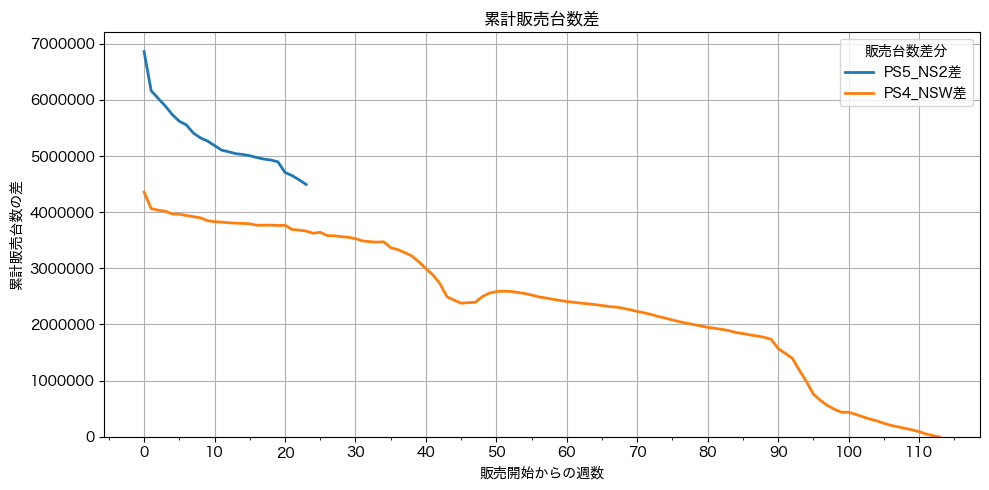

In [5]:
(fig4, d4) = ph.plot_cumsum_diffs(cmplist = [('NS2', 'PS5'), ('NSW', 'PS4')], xgrid=10)


In [6]:
d4

hw,PS5_NS2差,PS4_NSW差
0,6862029.0,4359277.0
1,6167379.0,4065277.0
2,6028303.0,4036422.0
3,5894283.0,4018033.0
4,5740595.0,3969019.0
...,...,...
109,NaN,122981.0
110,NaN,89985.0
111,NaN,47677.0
112,NaN,18702.0


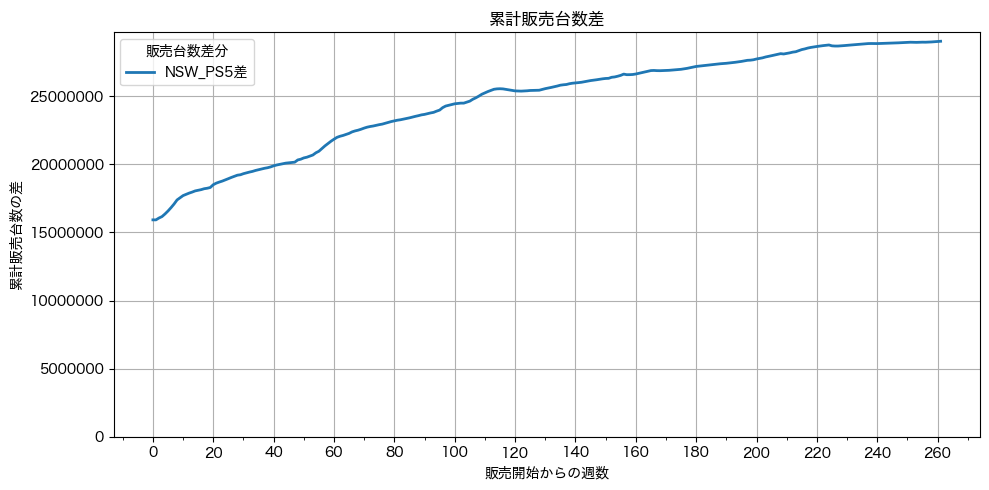

In [9]:
(fig5, d5) = ph.plot_cumsum_diffs(cmplist = [('PS5', 'NSW')], xgrid=20)

In [8]:
d5

hw,NSW_PS5差
0,15924007.0
1,15922189.0
2,16058441.0
3,16163160.0
4,16355889.0
...,...
257,28976623.0
258,28988251.0
259,29002857.0
260,29022028.0


/var/folders/p4/348jfj6522l78r8xkkk0csb40000gn/T/ipykernel_10427/222631020.py:26: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/hide/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


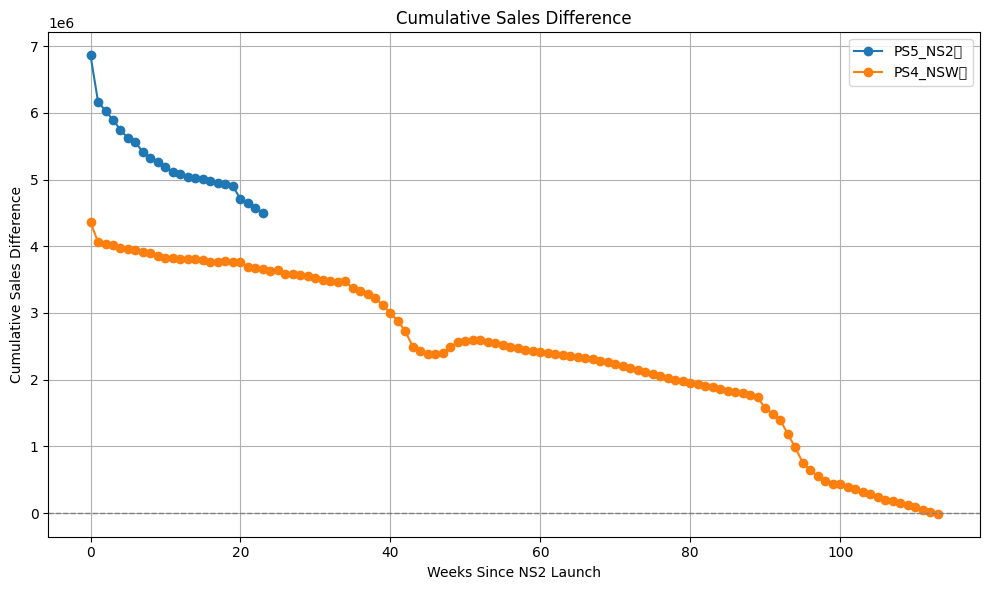

In [6]:
hard_sales_df = hs.load_hard_sales()
hard_event_df = he.load_hard_event()

d3 = hs.cumsum_diffs(hard_sales_df, [('NS2', 'PS5'), ('NSW', 'PS4')])

# ===== 汎用プロット（変更箇所） =====
# 表示対象のカラム名が不明でも d3 の全カラムを描画する
plt.figure(figsize=(10, 6))
if d3.empty:
    print('プロットするデータがありません')
else:
    # 各カラムをループしてプロット（インデックスを x 軸に使用）
    for col in d3.columns:
        # 数値列だけ描画する（安全対策）
        try:
            plt.plot(d3.index, d3[col], label=str(col), marker='o')
        except Exception:
            # 非数値列など描画不可ならスキップ
            continue
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.title('Cumulative Sales Difference')
    plt.xlabel('Weeks Since NS2 Launch')
    plt.ylabel('Cumulative Sales Difference')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()  
# ===== 変更箇所ここまで =====


In [7]:
d3

hw,PS5_NS2差,PS4_NSW差
0,6862029.0,4359277.0
1,6167379.0,4065277.0
2,6028303.0,4036422.0
3,5894283.0,4018033.0
4,5740595.0,3969019.0
...,...,...
109,NaN,122981.0
110,NaN,89985.0
111,NaN,47677.0
112,NaN,18702.0


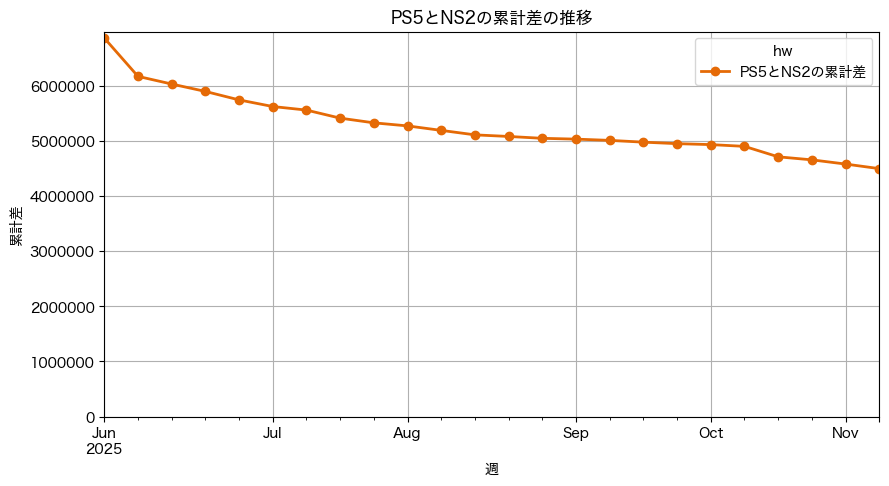

In [3]:
def cumsum_diff(df:pd.DataFrame, base_hw:str, cmp_hw:str) -> pd.DataFrame:
    cumsum_df = hs.pivot_cumulative_sales(df, hw=[base_hw, cmp_hw])
    # column:cmp_hwの値がNA以外になった最初の行の直前のindexを得る
    first_valid_index = cumsum_df[cmp_hw].first_valid_index()
    if first_valid_index is not None:
        idx_list = list(cumsum_df.index)
        pos = idx_list.index(first_valid_index)
        # 直前の行が存在する場合はそのindexから
        start_pos = max(pos - 1, 0)
        start_index = idx_list[start_pos]
        cumsum_df = cumsum_df[cumsum_df.index >= start_index]

    cumsum_df = cumsum_df.fillna(0)
    cumsum_df["diff"] = cumsum_df[base_hw] - cumsum_df[cmp_hw]
    cumsum_df = cumsum_df[cumsum_df["diff"] >= -20000]
    return cumsum_df[["diff"]].rename(columns={"diff": f"{base_hw}と{cmp_hw}の累計差"})

def plot_cumsum_diff(df:pd.DataFrame, base_hw:str, cmp_hw:str, marker:bool=True) -> None:
    cumsum_diff_df = cumsum_diff(df, base_hw, cmp_hw)

    fig, ax = plt.subplots(figsize=ph.get_figsize())
    plt.rcParams['font.family'] = 'Hiragino Sans'
    plt.rcParams['axes.unicode_minus'] = False
    if marker:
        marker_str = 'o'
    else:
        marker_str = ''
    cumsum_diff_df.plot(ax=ax, kind='line', marker=marker_str, 
                        linewidth=2, color="#E56A06")
    ax.set_title(f"{base_hw}と{cmp_hw}の累計差の推移")
    ax.set_xlabel("週")
    ax.set_ylabel("累計差")
    # 縦軸の表示を指数表示から整数表示に変更
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.ticklabel_format(style='plain', axis='y')
    ax.set_ylim(bottom=0)
    ax.grid(True)

plot_cumsum_diff(hard_sales_df, "PS5", "NS2")


<Axes: xlabel='delta_week'>

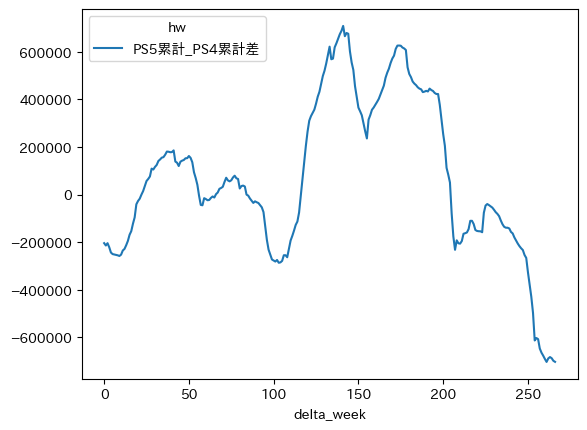

In [11]:
# 必要な処理

base_df = hs.load_hard_sales()
pv1 = hs.pivot_cumulative_sales_by_delta(base_df, hw=['PS4', 'PS5'])
pv1['PS5累計_PS4累計差'] = pv1['PS5'] - pv1['PS4']
pv2 = pv1.loc[:, ['PS5累計_PS4累計差']]
pv2.plot()


<Axes: xlabel='delta_week'>

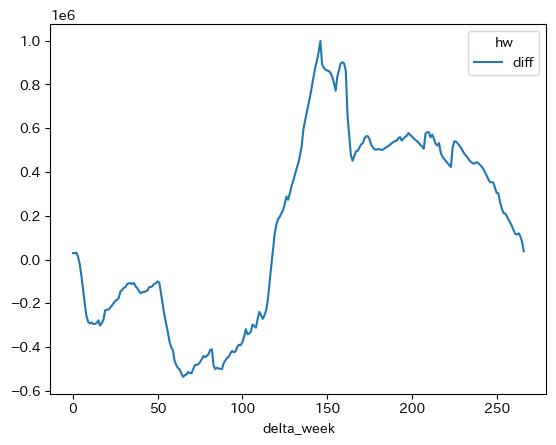

In [10]:
# 必要な処理

pv35 = hs.pivot_cumulative_sales_by_delta(base_df, hw=['PS3', 'PS5'])
pv35['diff'] = pv35['PS5'] - pv35['PS3']
pv352 = pv35.loc[:, ['diff']]
pv352.plot()

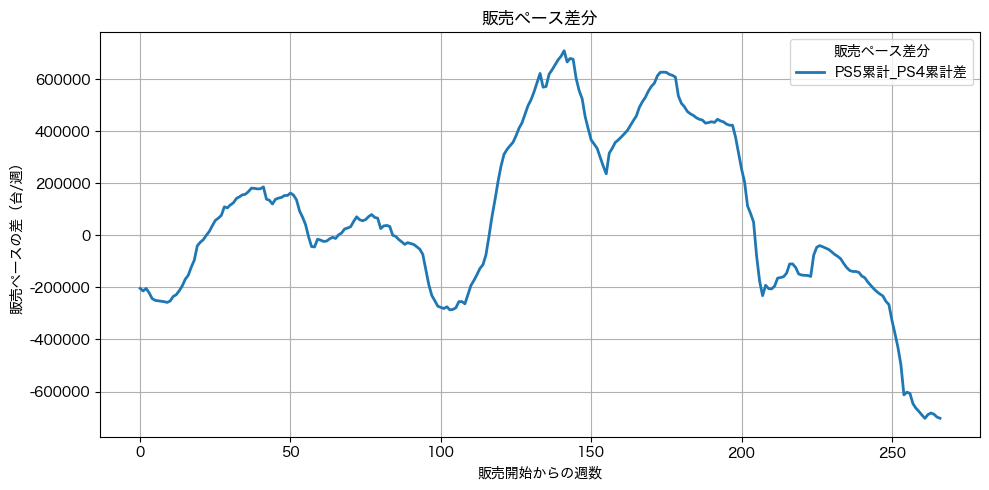

In [33]:
(fig, df) = ph.plot_sales_pase_diff('PS4', 'PS5')


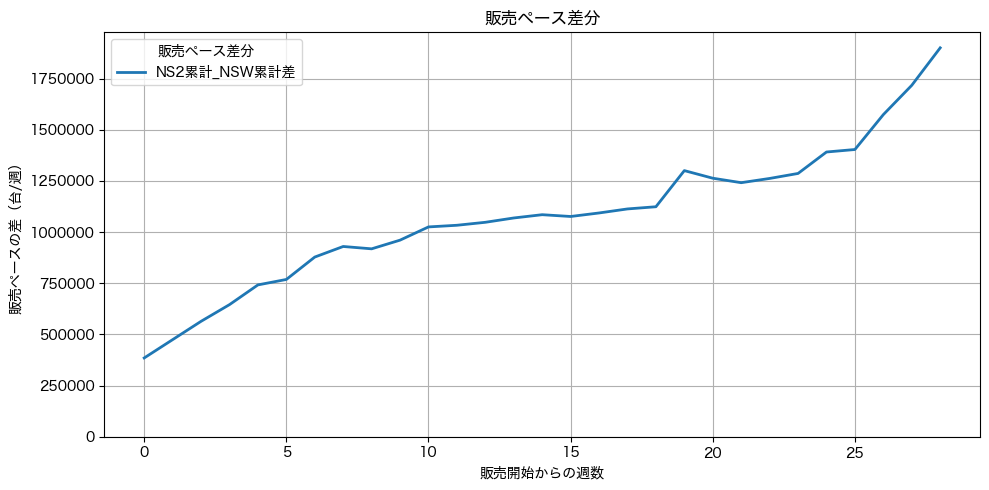

In [24]:
(fig, df) = ph.plot_sales_pase_diff('NSW', 'NS2', ybottom=0)

In [ ]:
df

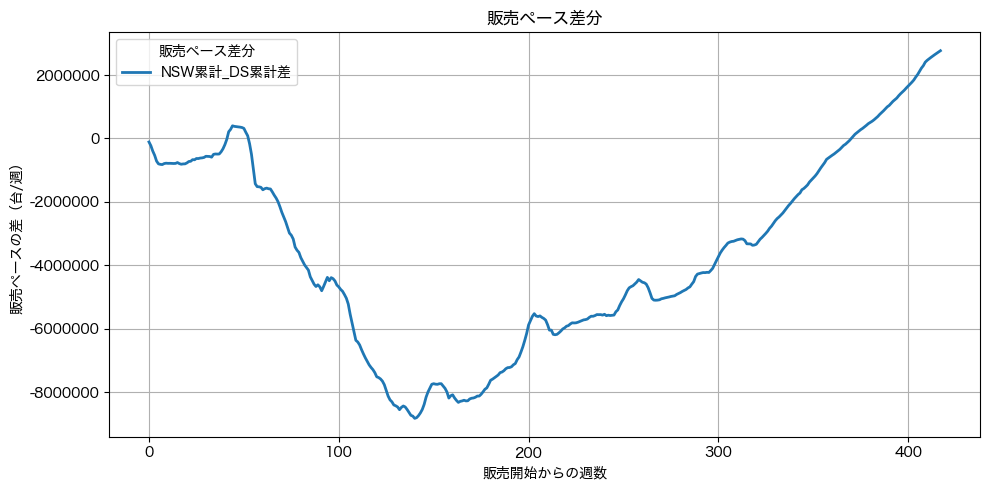

In [27]:
(fig, df) = ph.plot_sales_pase_diff('DS', 'NSW')